In [1]:
!pip install pytorch_lightning==0.9.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached pytorch_lightning-0.9.0-py3-none-any.whl (408 kB)
ERROR: pytorch-lightning-bolts 0.2.5rc1 has requirement pytorch-lightning>=1.0, but you'll have pytorch-lightning 0.9.0 which is incompatible.
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.0.8
    Uninstalling pytorch-lightning-1.0.8:
      Successfully uninstalled pytorch-lightning-1.0.8


In [1]:
from data_loaders.data_module import ChestDataModule
from utils.visualisation import showInRow
from models import get_model

from transforms.pretraining import Moco2TrainTransforms, Moco2ValTransforms
from transforms.finetuning import ChestTrainTransforms, ChestValTransforms

from models.baseline import BaseLineClassifier

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
seed_everything(12345)

Global seed set to 12345


12345

Loaded datasets: chest14
Before sampling length:  69219
After sampling length:  69219
Creating balanced dataloader
Batch 4


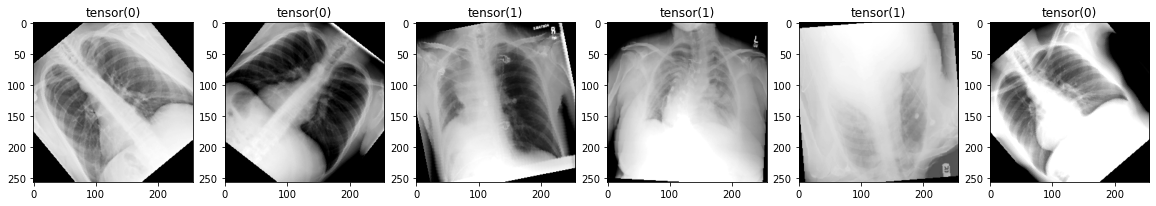

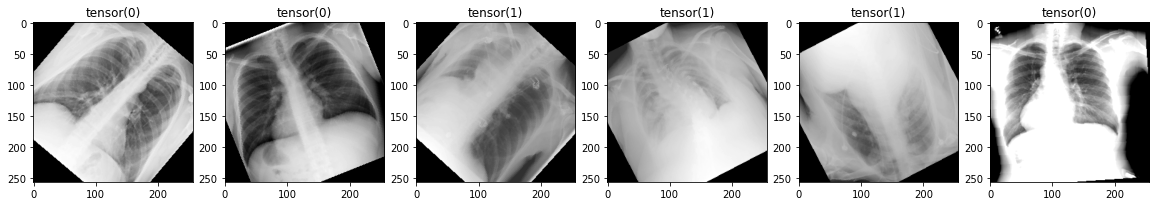

Batch 3


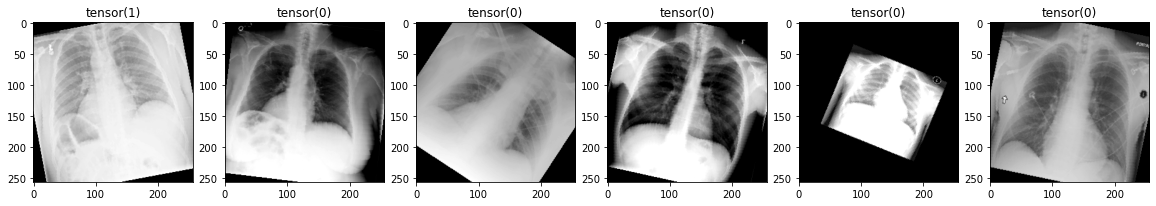

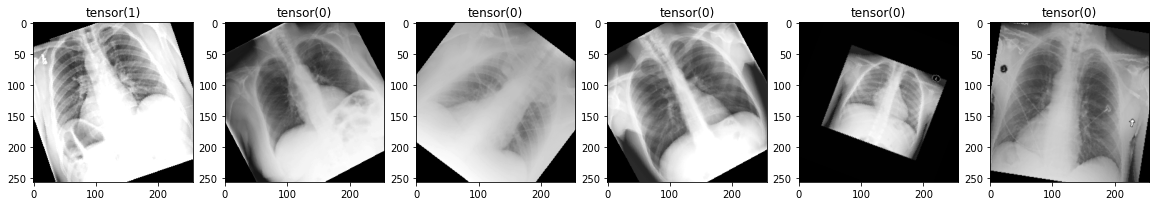

Batch 2


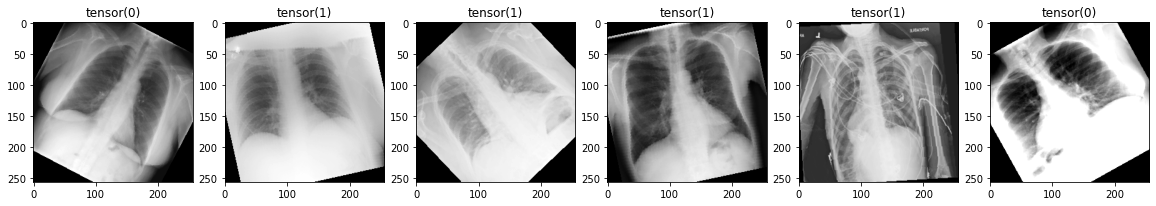

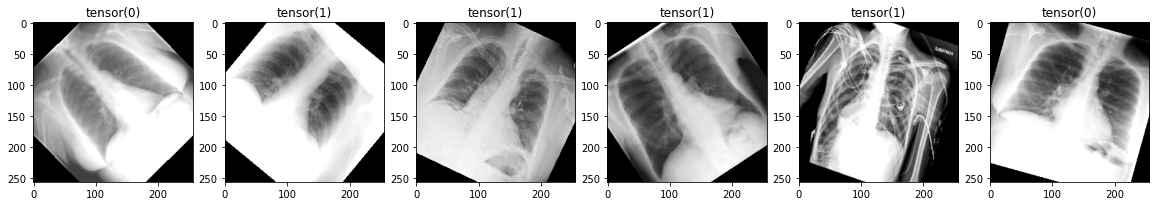

Batch 1


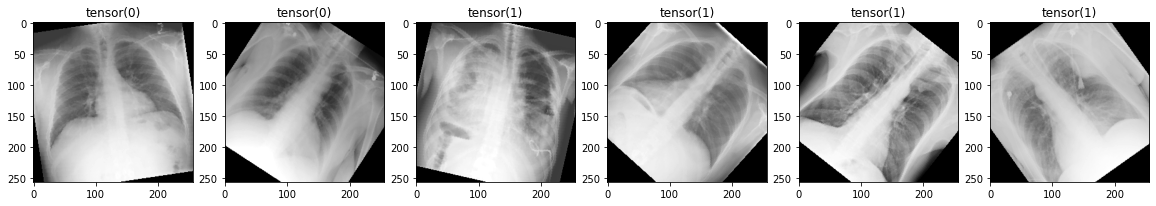

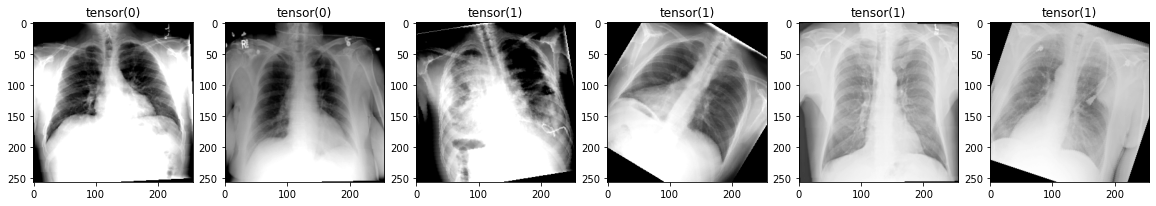

Batch 0


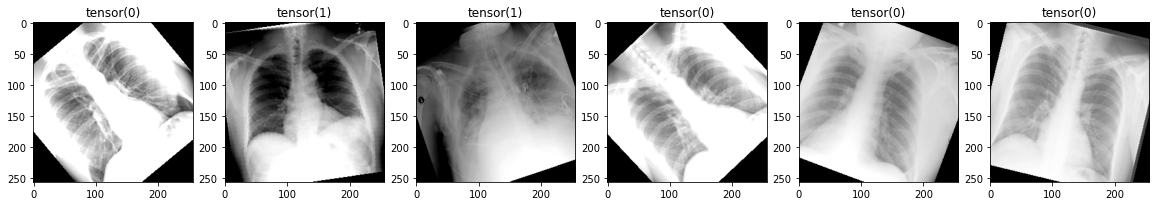

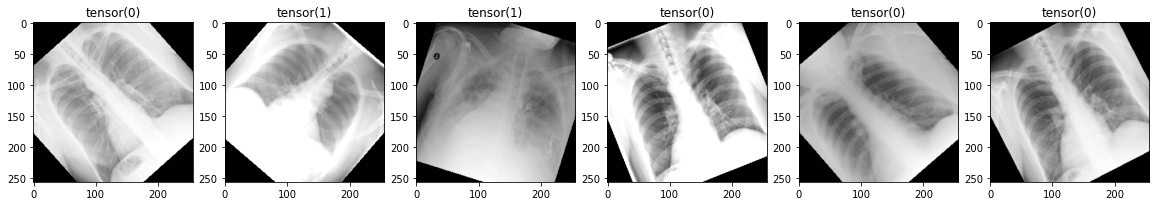

In [2]:
data_module = ChestDataModule(ds_list=["chest14"], batch_size=6, num_workers=2, balanced=True)
data_module.train_transforms = Moco2TrainTransforms(height=256)
data_module.val_transforms = Moco2ValTransforms(height=256)

batches = 4
for batch in data_module.train_dataloader():
    print("Batch",batches)
    img1, labels = batch["image"][0],batch['target']
    showInRow(img1, labels, tensor=True)
    img1, labels = batch["image"][1],batch['target']
    showInRow(img1, labels, tensor=True)
    batches -=  1
    if batches<0:
        break

Loaded datasets: chest14
Before sampling length:  69219
After sampling length:  6921
Batch 4


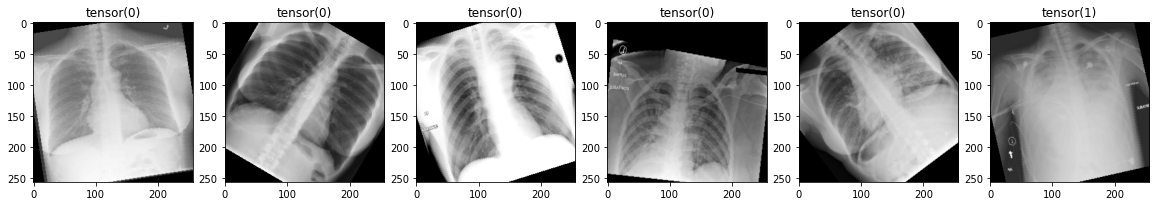

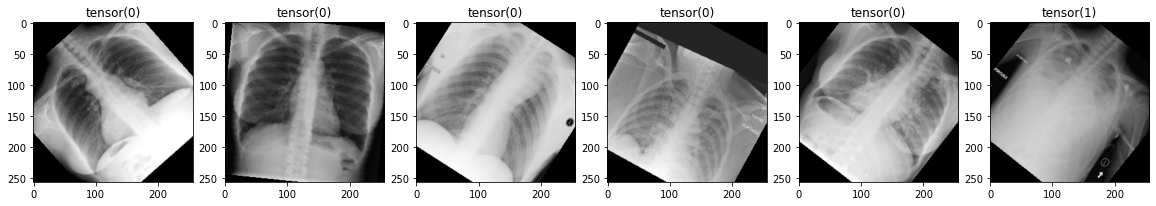

Batch 3


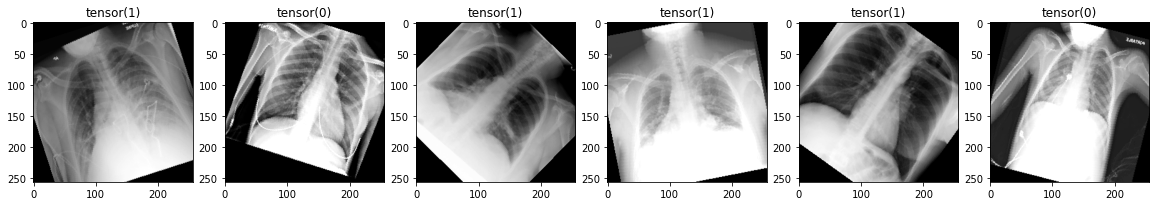

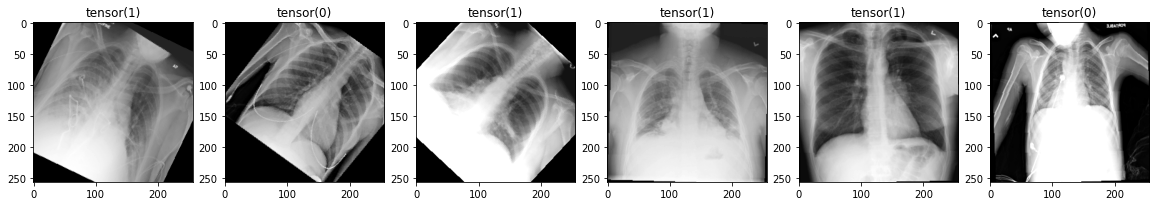

Batch 2


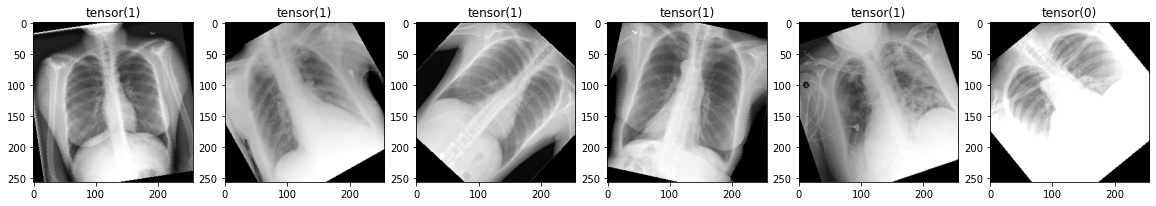

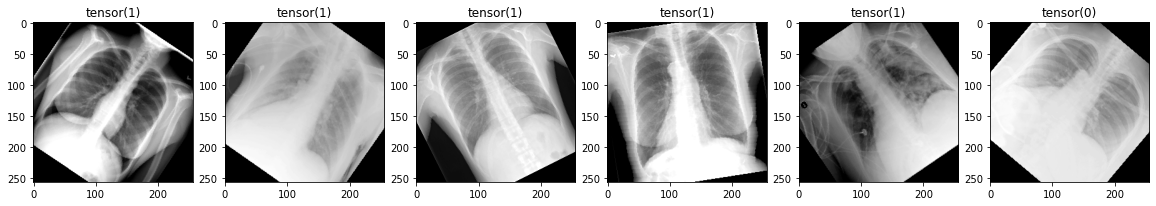

Batch 1


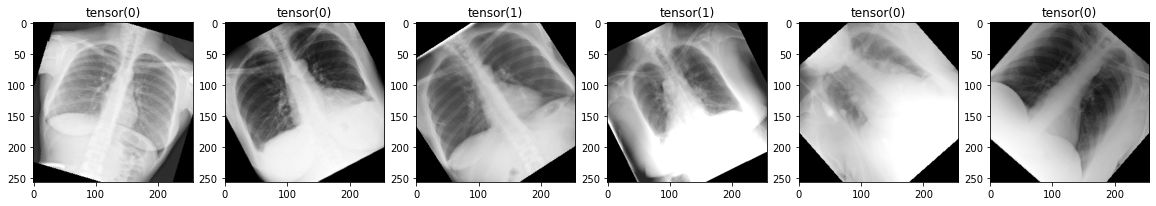

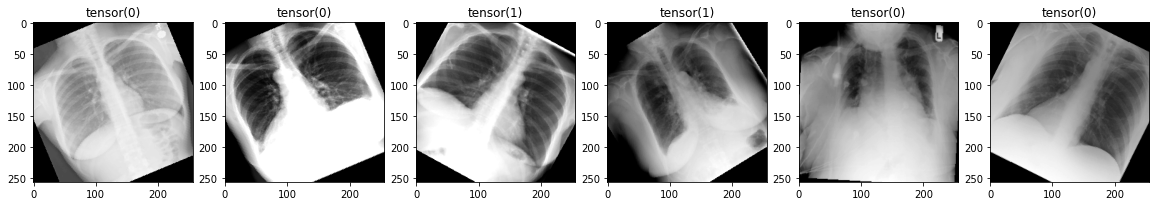

Batch 0


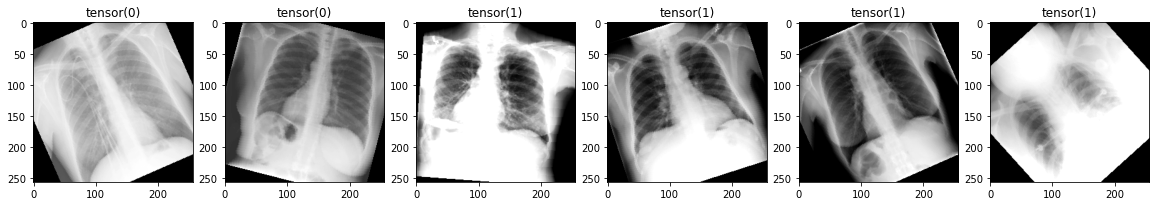

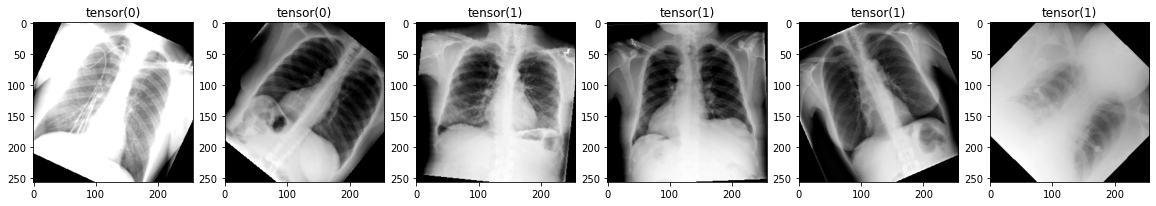

In [8]:
data_module = ChestDataModule(ds_list=["chest14"], batch_size=6, num_workers=2, balanced=True, train_fraction=0.1)
data_module.train_transforms = Moco2TrainTransforms(height=256)
data_module.val_transforms = Moco2ValTransforms(height=256)

batches = 4
for batch in data_module.train_dataloader():
    print("Batch",batches)
    img1, labels = batch["image"][0],batch['target']
    showInRow(img1, labels, tensor=True)
    img1, labels = batch["image"][1],batch['target']
    showInRow(img1, labels, tensor=True)
    batches -=  1
    if batches<0:
        break

In [4]:
import pandas as pd
import numpy as np

In [2]:
dm = ChestDataModule(["chexpert_5_01"], batch_size=16, num_workers=2, balanced=False)

Loaded datasets: chexpert_5_01


In [3]:
dm.train_transforms = ChestTrainTransforms(height=224)
dm.val_transforms = ChestValTransforms(height=224)

In [4]:
classifier = BaseLineClassifier(get_model("resnet18", pretrained=True), 
                                num_classes=5, 
                                linear=False,
                                learning_rate=1e-4,
                                b1=0.9,
                                b2=0.999,
                                weight_decay=1e-4,
                                multi_class=True,
                                mixup=True,
                                ct_reg=True)

wandb_logger = WandbLogger(name='baseline-NL-chexpert5-01-mixup-ct_reg-Adam-1e_4',project='thesis')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', 
                                      dirpath='logs/baseline/chexpert5/', 
                                      filename='NL-01-mixup-ct_reg-Adam-1e_4-{epoch:02d}-{val_loss:.4f}')

trainer = pl.Trainer(gpus=1, deterministic=True,
                     logger=wandb_logger, callbacks=[checkpoint_callback])

if torch.cuda.is_available():
    classifier = classifier.cuda()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(classifier, dm)

wandb: Currently logged in as: genvekt (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name     | Type     | Params
--------------------------------------
0 | model    | ResNet   | 11.2 M
1 | sigmoid  | Sigmoid  | 0     
2 | bce      | BCELoss  | 0     
3 | accuracy | Accuracy | 0     
--------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Before sampling length:  34055
After sampling length:  34055


/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Before sampling length:  13408
After sampling length:  13408


/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [5]:
for batch in dm.train_dataloader():
    batch['image'] = batch['image'].to("cuda")
    batch['target'] = batch['target'].to("cuda")
    classifier.training_step(batch, 0)
    break

Before sampling length:  134080
After sampling length:  134080
tensor([[0.3026, 0.7526, 0.3479, 0.6588, 0.6812],
        [0.3157, 0.7982, 0.4097, 0.5242, 0.7012],
        [0.3341, 0.6292, 0.4601, 0.5154, 0.7222],
        [0.3189, 0.6456, 0.5237, 0.5866, 0.5841],
        [0.2879, 0.6944, 0.4289, 0.5307, 0.6610]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([0.3118, 0.7040, 0.4341, 0.5631, 0.6699], device='cuda:0',
       grad_fn=<MeanBackward1>)
tensor(1.7822, device='cuda:0', grad_fn=<SumBackward0>)


In [9]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

In [2]:
df_full = pd.read_csv("datasets/chexpert_5_01.csv")

In [10]:
for p in tqdm(df_full['Path']):
    if not Path(p).exists():
        print(p)
    

100%|██████████| 47463/47463 [19:31<00:00, 40.50it/s]
